<a href="https://colab.research.google.com/github/Woozi1990/ICT303/blob/main/ICT303_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **ICT303 - Assignment 1**

**Your name: WU HAO**

**Student ID: 34251824**

**Email: chriswu0207@hotmail.com**



In this homework, you will build a model for predicting house prices. For this, you will use real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

Your task is to:
1. Develop a better model to reduce the prediction error. You can find some hints on the last section.
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!
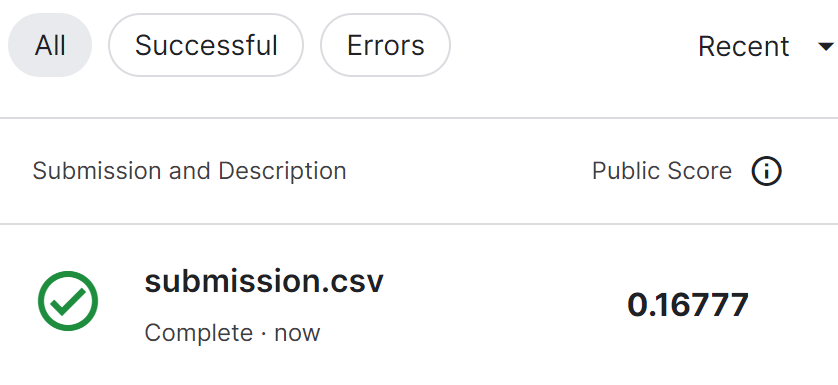




## **1. Accessing and Reading the Kaggle Data Sets**

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition.

The data includes multiple data types, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'.

The price of each house, namely the label, is only included in the training data set (it is a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). It is already part of colab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

from torch import nn
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter


Download the train and test dataset from [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) (in the Data tab). You will need to sign it to access the data. These are two Comma Separated Values (CSV) files containing training and test data respectively we use Pandas.

Save them into your google drive. To read them into your code, use the following command (from panda)

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment1/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_data()

train_data = pd.read_csv('data/train.csv')
test_data  = pd.read_csv('data/test.csv')


Finished!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **2. Data Preprocessing**



Althongh the values of 'MSSubClass' are numerics, but they just represent catagory, 'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt' represent date, so convert them to string as categorical features.

In [4]:
train_data['MSSubClass'] = train_data['MSSubClass'].astype(str)
test_data['MSSubClass'] = test_data['MSSubClass'].astype(str)
train_data['MoSold'] = train_data['MoSold'].astype(str)
test_data['MoSold'] = test_data['MoSold'].astype(str)
train_data['YrSold'] = train_data['YrSold'].astype(str)
test_data['YrSold'] = test_data['YrSold'].astype(str)
train_data['YearBuilt'] = train_data['YearBuilt'].astype(str)
test_data['YearBuilt'] = test_data['YearBuilt'].astype(str)
train_data['YearRemodAdd'] = train_data['YearRemodAdd'].astype(str)
test_data['YearRemodAdd'] = test_data['YearRemodAdd'].astype(str)
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].astype(str)
test_data['GarageYrBlt'] = test_data['GarageYrBlt'].astype(str)

Displays the correlation of all numeric features to "SalePrice" in train dataset and sorts them in descending order.

<Axes: >

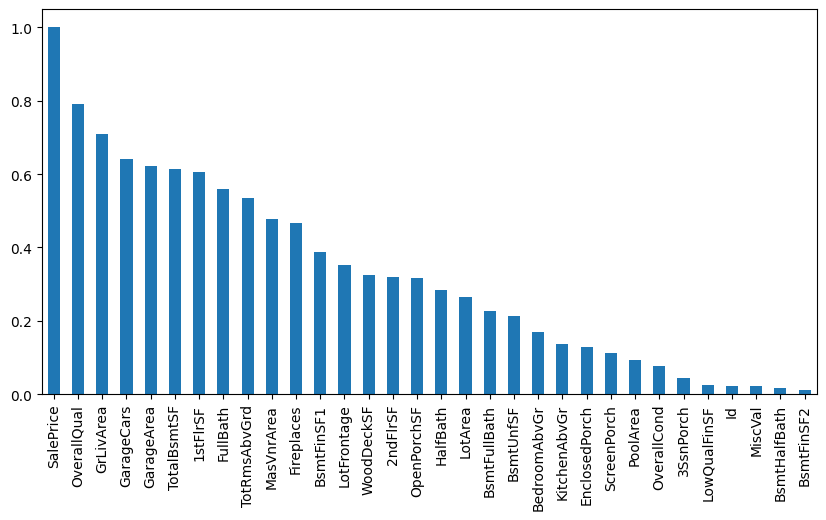

In [5]:
fig = plt.figure(figsize=(10,5))
abs(train_data.corr(numeric_only=True)['SalePrice']).sort_values(ascending=False).plot.bar()

Show the first 6 figures of features with respect to the 'SalePrice' to find any discrete value.

<Figure size 640x480 with 0 Axes>

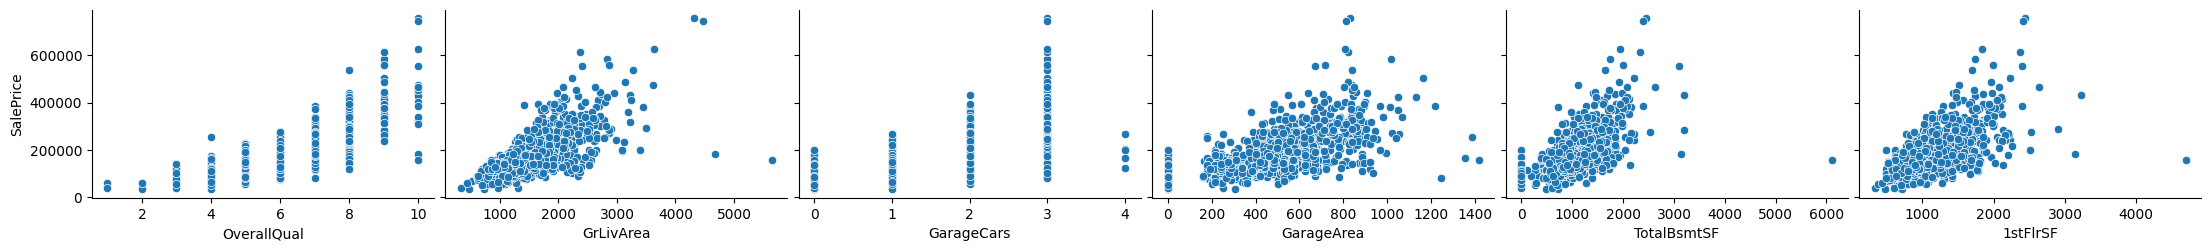

In [6]:
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True,aspect=1.5)
plt.show()

Drop all discrete values.

In [7]:
train_data = train_data.drop(train_data[(train_data['OverallQual'] == 10 ) & (train_data['SalePrice'] < 200000)].index)
train_data = train_data.drop(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index)
train_data = train_data.drop(train_data[(train_data['GarageArea'] > 1200) & (train_data['SalePrice'] < 300000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF'] > 4000)].index)
train_data = train_data.drop(train_data[(train_data['1stFlrSF'] > 4000)].index)

<Figure size 640x480 with 0 Axes>

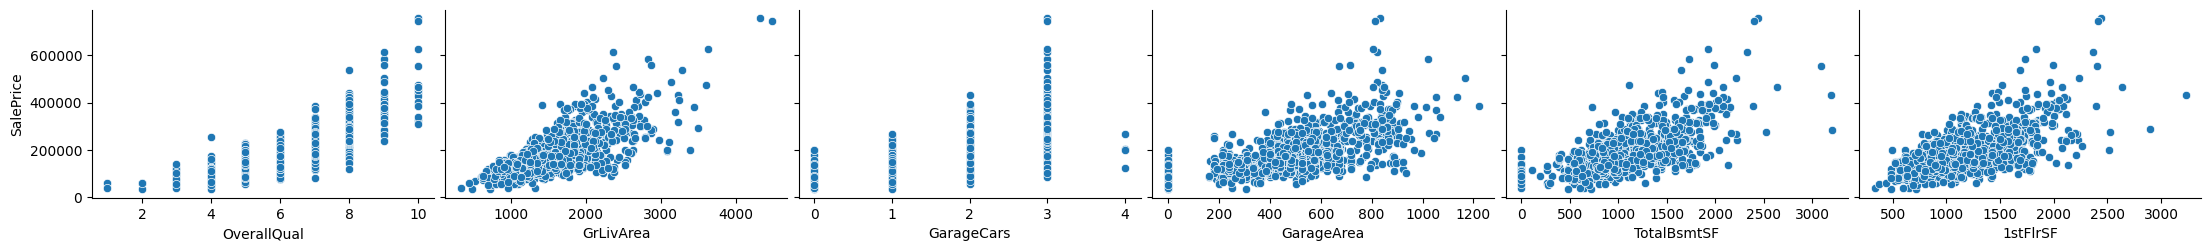

In [8]:
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True,aspect=1.5)
plt.show()

Handling missing data. Firstly, show the features with missing data in train dataset and test dataset.

In [9]:
train_missing = train_data.isnull().sum()
train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
train_missing

PoolQC          1449
MiscFeature     1402
Alley           1364
Fence           1174
MasVnrType       871
FireplaceQu      689
LotFrontage      258
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

In [10]:
test_missing = test_data.isnull().sum()
test_missing = test_missing.drop(test_missing[test_missing==0].index).sort_values(ascending=False)
test_missing

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

According to Kaggle's data description, the features 'MSSubClass','MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical','Utilities' are categorical features, so I use the mode to fill the missing values of the two datasets separately, other features will be handled differently.

In [11]:
mode_lists = ['MSSubClass','MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical','Utilities']
for col in mode_lists:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

'LotFrontage' is the Linear feet of street connected to property, I group the 'Neighborhood' and use their median to fill missing values.

In [12]:
train_data['LotFrontage'] = train_data.groupby('Neighborhood',group_keys=False)['LotFrontage'].apply(lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby('Neighborhood',group_keys=False)['LotFrontage'].apply(lambda x: x.fillna(x.median()))

According to the data description in Kaggle, missing data means this house does not have this feature in 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2 ', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType'. So I use "None" to fill them.

In [13]:
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType']
for col in none_lists:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

And the features 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea','TotalBsmtSF' are numeric features, I use 0 to fill the missing values.

In [14]:
zero_lists = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea',
              'TotalBsmtSF']
for col in zero_lists:
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

From data description of "Functional", it says "Assume typical unless deductions are warranted", so fill "Typ" for missing values.

In [15]:
train_data['Functional'] = train_data['Functional'].fillna('Typ')
test_data['Functional'] = test_data['Functional'].fillna('Typ')

Print how many missing values left in train data and test data. After the process above, the result should be 0.

In [16]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [17]:
print(train_data.shape)
print(test_data.shape)

(1455, 81)
(1459, 80)


As stated above, we have a wide variety of datatypes. Before we feed it into a  network we need to perform some amount of processing.

Let's start with the **numerical features**. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

This process is called **normalization** or **standardisation**. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

Write below the code that does the normalization for each numerical features:

In [18]:
train_features = train_data.iloc[:,1:-1]
test_features = test_data.iloc[:,1:]
print(train_features.shape)
print(test_features.shape)

(1455, 79)
(1459, 79)


In [19]:
train_numerical_features = train_features.dtypes[train_features.dtypes != 'object'].index
train_features[train_numerical_features] = train_features[train_numerical_features].apply(lambda x: (x - x.mean()) / (x.std()))

test_numerical_features = test_features.dtypes[test_features.dtypes != 'object'].index
test_features[test_numerical_features] = test_features[test_numerical_features].apply(lambda x: (x - x.mean()) / (x.std()))

print(train_features.shape)
print(test_features.shape)

(1455, 79)
(1459, 79)


And other variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us. Since all missing values are handled, we don't need dummy_na=True

In [31]:
all_features = pd.concat((train_features, test_features))
all_features = pd.get_dummies(all_features)

all_features = all_features.astype(float)
all_features.shape

(2914, 611)

In [22]:
n_train = train_data.shape[0]
n_train

1455

#########################################################################################################################################################################################################################################

The above two processes need to calculate the mode and median, so as not to mix the data of the two datasets, I processed the two datasets separately. Now we can merge the two datasets and drop the 'Id' and 'SalePrice'.

In [56]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
all_features.values

array([[-0.2299521348802988, -0.20183048067317433, 0.6580658166484564,
        ..., nan, nan, nan],
       [0.4697140220641496, -0.08508272339749762, -0.07006023903481638,
        ..., nan, nan, nan],
       [-0.09001890349140913, 0.08242492834586464, 0.6580658166484564,
        ..., nan, nan, nan],
       ...,
       [4.335658898813174, 2.054445229250958, -0.750843798839486, ...,
        False, False, False],
       [-0.3312098790277122, 0.12548416033088228, -0.750843798839486,
        ..., False, False, False],
       [0.24024344070790646, -0.03877719651616674, 0.6411271065058886,
        ..., False, False, False]], dtype=object)

In [ ]:
missing_data = all_features.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data==0].index).sort_values(ascending=False)
missing_data

PoolQC          2905
MiscFeature     2810
Alley           2716
Fence           2343
FireplaceQu     1419
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
dtype: int64

According to the data description in Kaggle, features 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2 ', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType' missing means this house does not have this feature. So I use "None" to fill them.


In [ ]:
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType']
for col in none_lists:
    all_features[col] = all_features[col].fillna('None')

And the features 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea','TotalBsmtSF' are numeric features, I use 0 to fill the missing values.

In [ ]:
zero_lists = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea',
              'TotalBsmtSF']
for col in zero_lists:
    all_features[col] = all_features[col].fillna(0)

From data description of "Functional", it says "Assume typical unless deductions are warranted", so fill "Typ" for missing values.

In [ ]:
all_features['Functional'] = all_features['Functional'].fillna('Typ')

Print how many missing values left. After the process above, the result should be 0.

In [ ]:
print(all_features.isnull().sum().sum())

0


In [ ]:
print(all_features.shape)

(2914, 79)


As stated above, we have a wide variety of datatypes. Before we feed it into a  network we need to perform some amount of processing.

Let's start with the **numerical features**. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

This process is called **normalization** or **standardisation**. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

Write below the code that does the normalization for each numerical features:

In [ ]:
# Normalize the numerical features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

all_features.shape

(2914, 79)

And other variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us. Since all missing values are handled, we don't need dummy_na=True

In [28]:
a = pd.get_dummies(all_features,dtype=int)

In [ ]:
all_features.shape

(2914, 611)

#############################################################################################################################################################################################################################################################################

Finally, split all the data into training set and test set for training

In [33]:
n_train = train_data.shape[0]


# the train feature are in all_features[:n_train].values - need to convert them into a pytorch tensor??
train_features =  torch.tensor(all_features[:n_train].values, dtype=torch.float32)

# the test feature are in all_features[n_train:].values - need to convert them into a pytorch tensor??
test_features  = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

# the train labels are in train_data.SalePrice.values - need to convert them into a pytorch tensor??
train_labels   = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_labels = train_labels.to(device)

torch.Size([1455, 611])
torch.Size([1459, 611])
torch.Size([1455, 1])


## **3. Training**

### **3.1. Loss function**
To get started, train an MLP model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

To this end, use the codes you developed in Lab 4. However, we may need to test with a better loss function to achieve better results. In fact, house prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy between the predicted price and the correct price in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in the Kaggle competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

I use linear regression to predict house price. I tried using MLP, but the performance is not as good as linear regression. Valid loss sometimes does not converge. And the higher the number of layers of MLP, the higher the loss.

In [34]:
class Model(nn.Module):
  def __init__(self, input, lr, weight_decay):
     super().__init__()
     self.net = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(input,1)
        # nn.ReLU(),
        # # nn.Dropout(0.5),
        # nn.Linear(512,256),
        # nn.ReLU(),
        # nn.Linear(256,128),
        # nn.ReLU(),
        # nn.Linear(128,1)
        )
     self.lr = lr
     self.weight_decay = weight_decay

  def forward(self,X):
    return self.net(X)

  def loss(self, output, label):
    criterion = nn.MSELoss()
    return criterion(output, label)

  def log_rmse(self, features, labels):
    clipped_preds = torch.clamp(self.net(features),1,float('inf'))
    rmse = torch.sqrt(self.loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

  def optimizer(self):
    return torch.optim.Adam(self.parameters(), self.lr, weight_decay=self.weight_decay)
    # return torch.optim.SGD(self.parameters(), self.lr, weight_decay=self.weight_decay)

In [35]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, i=1):
  train_ls, test_ls = [],[]
  last_loss=np.inf

  dataset = torch.utils.data.TensorDataset(*(train_features, train_labels))
  train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

  optimizer = net.optimizer()

  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      output = net(X)
      l = net.loss(output,y)
      l.backward()
      optimizer.step()

    net.eval()
    summary_name = 'fold '+ str(i)+' train/valid loss'
    train_log_rmse = net.log_rmse(train_features, train_labels)
    train_ls.append(train_log_rmse)
    writer.add_scalars(summary_name,{"train loss":train_log_rmse},epoch)

    if test_labels is not None:
      test_log_rmse = net.log_rmse(test_features, test_labels)
      test_ls.append(test_log_rmse)
      writer.add_scalars(summary_name,{"valid loss":test_log_rmse},epoch)
      if test_log_rmse>last_loss:
        torch.save(net.state_dict(), 'saved_model.pth')
      last_loss = test_log_rmse

  return train_ls, test_ls

### **3.2. k-Fold Cross-Validation**

To get good performance, you usually need to select the network architecture. This includes the type of network, the number of layers, the number of hidden neurons in each layer, the learning rate, the batch size, etc. These are called **hyper paramters**.

However, it is difficult to know which configuration of the hyperparameters above would achieve the best performance. Thus in practice, we need to try multiple configurations (i.e., choices of the hyperparameters), evaluate the performance of each configuration, and pick the one that gives the best performance.

To assess the performance of a given configuratation, you need to take the training set and randomly divide it into two subsets:
- one subset will be called training set (usually 80% of the entire data set),
- the second one will be called validation set (usually 20% of the entire data set.

Then, train your model on the training set and test it on the validation set. Repeat this process $k$ times and average the performance over all the run. This will then be the performance of this configuration. This process is called **$k-$fold cross validation**. $k$ is usually chosen to be $5$ or $10$.

Run this procedure for each of the configurations you defined and pick the one that gives the best performance.

To use it, first we need a function that returns the i-th fold of the data in a k-fold cross-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data.

Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [36]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [37]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):

      net = Model(train_features.shape[1], learning_rate, weight_decay)
      net.to(device)
      data = get_k_fold_data(k, i, X_train, y_train)

      # train on data and return the train and validation errors in train_ls and valid_ls, respectively
      # to be implemented here
      train_ls, valid_ls = train(net, *data, num_epochs,learning_rate, weight_decay, batch_size,i)

      train_l_sum += train_ls[-1]
      valid_l_sum += valid_ls[-1]

      writer.add_scalars('Train/Valid loss',{'Train loss':train_ls[-1],'Valid loss':valid_ls[-1]},i)
      print('fold %d, train rmse: %f, valid rmse: %f' % (i, train_ls[-1], valid_ls[-1]))

    return train_l_sum / k, valid_l_sum / k

Finding a good choice of the hyperparameters can take quite some time, depending on how many things one wants to optimize over. Within reason the $k$-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

In [43]:
%load_ext tensorboard
%load_ext tensorboard

# Clear any logs from previous runs
%rm -rf ./runs/Kaggle_house_price_prediction

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Kaggle_house_price_prediction')

k, num_epochs, lr, weight_decay, batch_size = 5, 300, 5, 0, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

writer.close()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
fold 0, train rmse: 0.142674, valid rmse: 0.157539
fold 1, train rmse: 0.137557, valid rmse: 0.154768
fold 2, train rmse: 0.133624, valid rmse: 0.156421
fold 3, train rmse: 0.140229, valid rmse: 0.149270
fold 4, train rmse: 0.136702, valid rmse: 0.147306
5-fold validation: avg train rmse: 0.138157, avg valid rmse: 0.153061


In [ ]:
tensorboard --logdir runs

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $k$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.


##  **4. Predict and Submit**

Once you have figured out what a good choice of hyperparameters should be, you might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

So your task here is that once you have decided what are the best hyperparameters, train on the entire Kaggle training set, test it on the Kaggle test set, save the result as a .csv file and submit it to Kaggle. The steps are quite simple:
* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

You need to include a screenshot of your results in the assignment submission.

In [44]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
  net = Model(train_features.shape[1], lr, weight_decay)
  net.to(device)
  net.eval()
  train_ls, _ = train(net, train_features, train_labels, None, None,
                      num_epochs, lr, weight_decay, batch_size)

  print(f'train log rmse {float(train_ls[-1]):f}')
  preds = net(test_features).detach().cpu().numpy()

  test_data.loc[:,('SalePrice')] = pd.Series(preds[:,0])

  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
  submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)


train log rmse 0.130127


## **5. What you need to do in this assignment**

In this assignment, you need to come up with the best neural network that can predict the house prices. This includes:
- The choice of the network: convolutional network, MLP, a combination, ...
- Setting the hyperparameters including the number of layers and the number of neurons in each layer.
- Train it on the Kaggle train set and test it on the Kaggle test set.

You may want to consider the following **hints**:
1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?


**What to submit**
- The colab notebook that implements the solution. You can update directly this notebook, as as many sections as you want. When I run your notebook, it  should load the Kaggle data. Make sure you provide enough explanation of your work.
- A screenshot of your score on Kaggle.
